# Waste Classification

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import zipfile

zip_path = "/content/drive/MyDrive/Waste_Project/garbage-classification.zip"
extract_path = "/content/waste_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [12]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [13]:
dataset_path = "/content/waste_dataset"
classes = os.listdir(dataset_path)
print("Classes found:", classes)

# Count images per class
for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    print(f"{cls}: {len(os.listdir(cls_path))} images")


Classes found: ['shoes', 'clothes', 'cardboard', 'metal', 'glass', 'plastic', 'battery', 'trash', 'biological', 'paper']
shoes: 1977 images
clothes: 5327 images
cardboard: 1852 images
metal: 1076 images
glass: 3198 images
plastic: 2095 images
battery: 944 images
trash: 959 images
biological: 997 images
paper: 1787 images


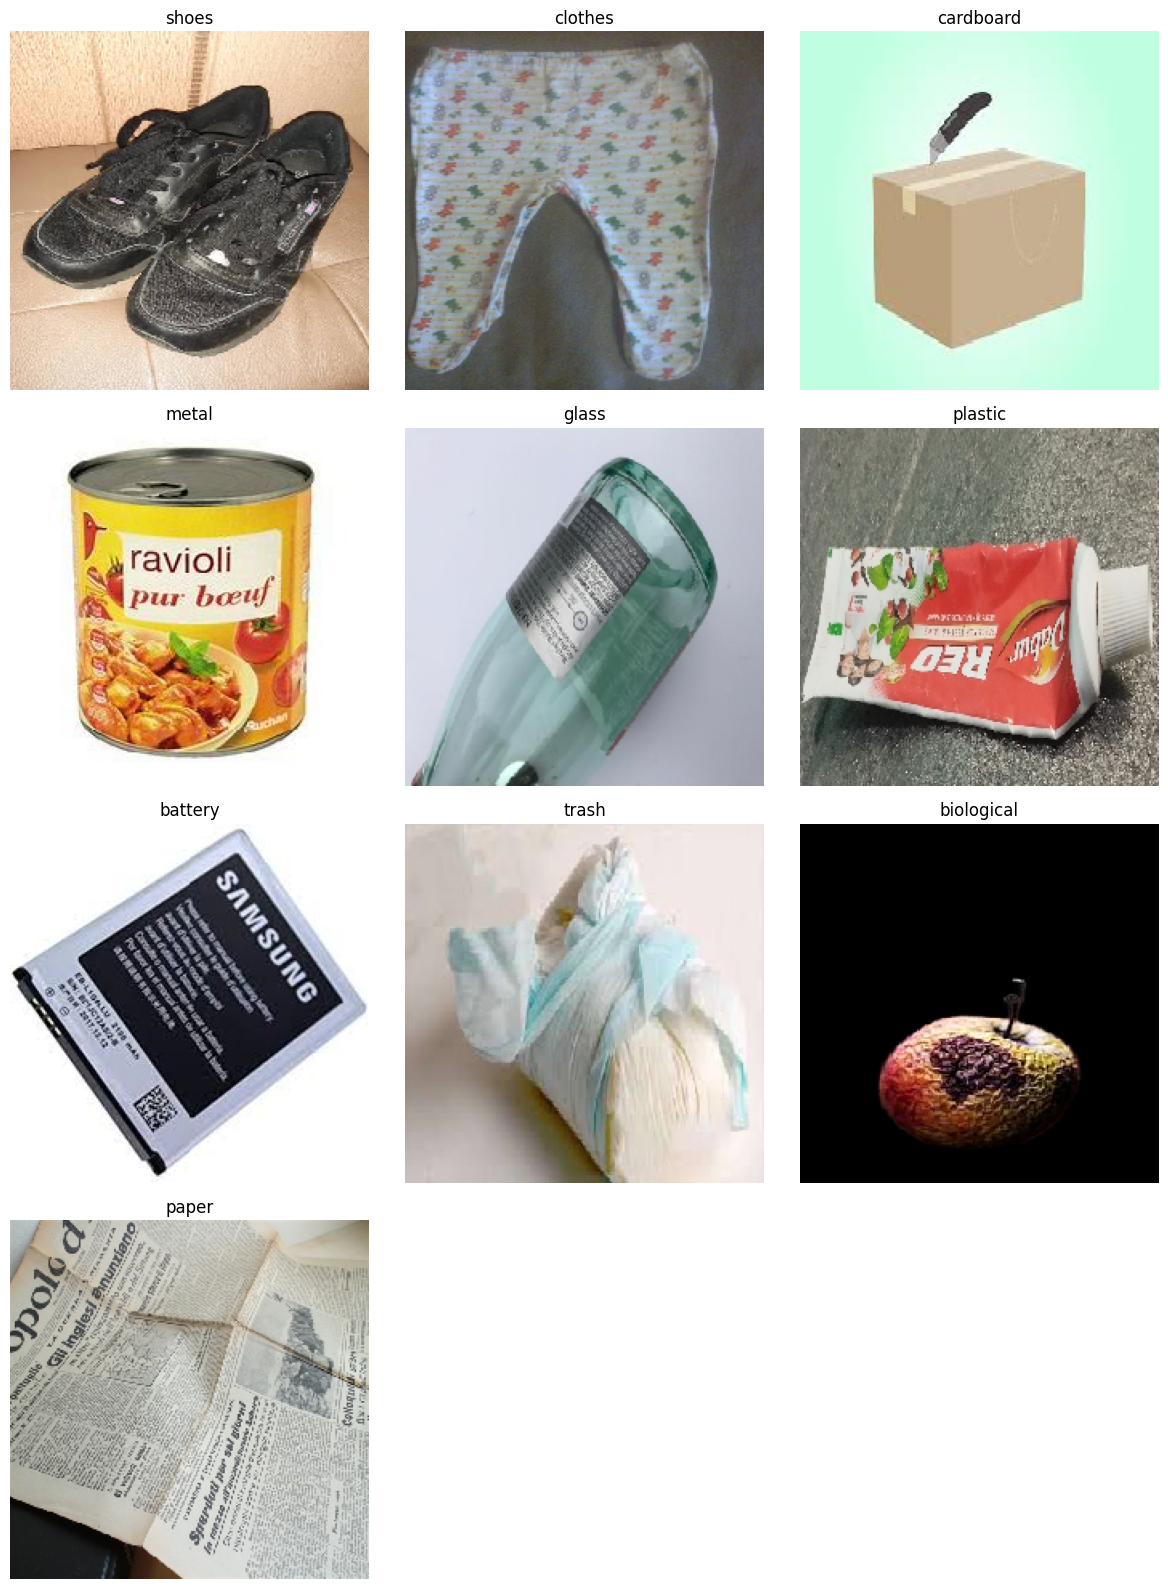

In [14]:
import math

# Number of classes
num_classes = len(classes)
cols = 3  # you can keep 3 columns
rows = math.ceil(num_classes / cols)

plt.figure(figsize=(cols*4, rows*4))  # adjust figure size

for i, cls in enumerate(classes):
    img_path = os.path.join(dataset_path, cls, os.listdir(os.path.join(dataset_path, cls))[0])
    img = load_img(img_path, target_size=(224,224))  # resize to 224x224

    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()



In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [16]:
dataset_path = "/content/waste_dataset"
img_height, img_width = 224, 224
batch_size = 32


In [17]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Normalize pixels
    validation_split=0.15, # 15% validation
    horizontal_flip=True,
    rotation_range=20
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 17185 images belonging to 10 classes.
Found 3027 images belonging to 10 classes.


In [18]:
from sklearn.model_selection import train_test_split
import shutil

# Path where test set will be stored
test_path = "/content/waste_test"
os.makedirs(test_path, exist_ok=True)

classes = os.listdir(dataset_path)
for cls in classes:
    os.makedirs(os.path.join(test_path, cls), exist_ok=True)

    # List all images in class
    images = os.listdir(os.path.join(dataset_path, cls))

    # Split 15% for test
    test_images = np.random.choice(images, size=int(0.15*len(images)), replace=False)

    # Move to test folder
    for img in test_images:
        src = os.path.join(dataset_path, cls, img)
        dst = os.path.join(test_path, cls, img)
        shutil.move(src, dst)


In [19]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3027 images belonging to 10 classes.


In [20]:
# Create an iterator explicitly
train_iterator = iter(test_generator)

# Get one batch
x_batch, y_batch = next(train_iterator)

print("Batch shape:", x_batch.shape)
print("Labels shape:", y_batch.shape)


Batch shape: (32, 224, 224, 3)
Labels shape: (32, 10)


In [21]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


In [22]:
num_classes = len(train_generator.class_indices)  # number of waste classes

# Load MobileNetV2 base model (without top classification layer)
base_model = MobileNetV2(weights='imagenet', include_top=False,
                         input_shape=(224,224,3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
# Recreate training generator
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Recreate validation generator
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 14611 images belonging to 10 classes.
Found 2574 images belonging to 10 classes.


In [25]:
epochs = 10 # you can increase later
history = model.fit( train_generator, validation_data=validation_generator, epochs=epochs )

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 266s 539ms/step - accuracy: 0.4004 - loss: 1.8419 - val_accuracy: 0.7308 - val_loss: 0.9055
Epoch 2/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 220s 482ms/step - accuracy: 0.7462 - loss: 0.8285 - val_accuracy: 0.7953 - val_loss: 0.6818
Epoch 3/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 216s 473ms/step - accuracy: 0.8019 - loss: 0.6261 - val_accuracy: 0.8213 - val_loss: 0.6008
Epoch 4/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 215s 471ms/step - accuracy: 0.8368 - loss: 0.5282 - val_accuracy: 0.8217 - val_loss: 0.5683
Epoch 5/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 219s 479ms/step - accuracy: 0.8433 - loss: 0.4787 - val_accuracy: 0.8287 - val_loss: 0.5461
Epoch 6/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 216s 473ms/step - accuracy: 0.8684 - loss: 0.4318 - val_accuracy: 0.8364 - val_loss: 0.5305
Epoch 7/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 215s 470ms/step - accuracy: 0.8680 - loss: 0.4072 - val_accuracy: 0.8450 - val_loss: 0.5010
Epoch 8/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 218s 476ms/step - accuracy: 0.8696 -

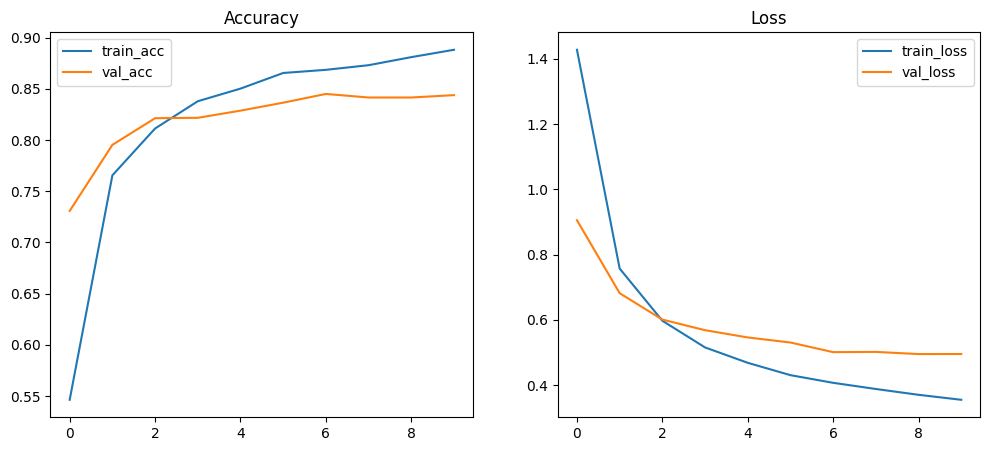

In [26]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()
plt.show()


In [27]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")


95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.9034 - loss: 0.3242
Test Accuracy: 89.13%


95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step


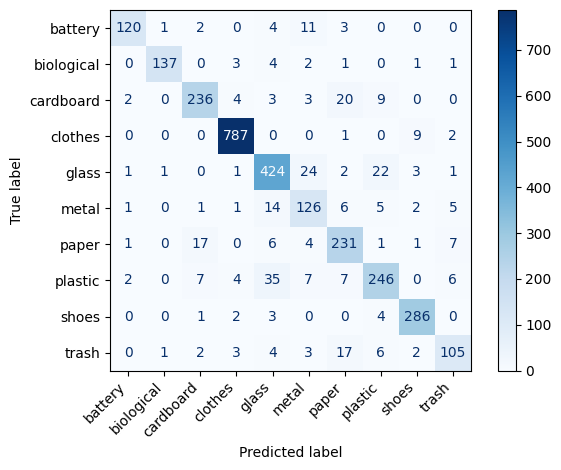

In [28]:
# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Display
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(cm, display_labels=list(test_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()


In [29]:
model.save("/content/drive/MyDrive/waste_classification_mobilenetv2.h5")



In [30]:
from tensorflow.keras.preprocessing import image
import os

def predict_waste(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    img = image.img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)
    class_names = list(train_generator.class_indices.keys())

    return class_names[np.argmax(pred)], np.max(pred)

# Example
# Find a sample plastic image that exists in the test set
plastic_test_path = os.path.join(test_path, 'plastic')
plastic_images_in_test = os.listdir(plastic_test_path)

if plastic_images_in_test:
    sample_plastic_image_path = os.path.join(plastic_test_path, plastic_images_in_test[0])
    predicted_class, confidence = predict_waste(sample_plastic_image_path)
    print(f"Predicted class: {predicted_class}, Confidence: {confidence:.2f}")
else:
    print("No plastic images found in the test directory to predict.")



1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted class: paper, Confidence: 0.36


In [31]:
import pandas as pd

results = []
class_names = list(test_generator.class_indices.keys())

for i, fname in enumerate(test_generator.filenames):
    results.append({
        "Image": fname,
        "Actual": class_names[y_true[i]],
        "Predicted": class_names[y_pred_classes[i]]
    })

df = pd.DataFrame(results)
df.to_csv("/content/drive/MyDrive/waste_predictions.csv", index=False)

